In [ ]:
import pandas as pd
import numpy as np
# from datasets import Dataset, load_metric
# from sklearn.model_selection import train_test_split
# from transformers import TrainingArguments, Trainer
# from transformers import BertForSequenceClassification, BertTokenizer
# import json
# from transformers import TrainerCallback, EarlyStoppingCallback
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [ ]:
preds = pd.read_csv('/content/preds.csv')
preds = preds.drop(["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.1.1", "Unnamed: 0.1.1.1", "Unnamed: 0.1.1.1.1", "Unnamed: 0.1.1.1.1.1", "Unnamed: 0.1.1.1.1.1.1"], axis=1)


In [ ]:
feats = ['bert-base-uncased-wiki', 'bert-base-uncased-sports', 'bert-base-uncased-scouting']
label = '# label'
x_train, x_test, y_train, y_test = train_test_split(preds[feats].values,
                                                    preds[label].values,
                                                    test_size=0.30,
                                                    random_state=0)
print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
print("Sample of features and labels:")

# Take a look at the first 25 training features and corresponding labels
for n in range(0,24):
    print(x_train[n], y_train[n])

Training Set: 1089, Test Set: 467 

Sample of features and labels:
[1 1 1] 1.0
[0 0 0] 0.0
[1 1 1] 1.0
[0 0 0] 0.0
[0 0 0] 0.0
[0 1 0] 1.0
[1 1 1] 1.0
[1 1 1] 1.0
[1 1 1] 1.0
[0 0 0] 0.0
[1 1 1] 1.0
[1 1 1] 0.0
[0 1 1] 1.0
[0 0 0] 0.0
[0 0 0] 0.0
[1 0 0] 0.0
[0 0 0] 0.0
[0 0 0] 0.0
[0 0 0] 0.0
[0 0 0] 0.0
[1 1 1] 1.0
[0 0 0] 0.0
[0 0 0] 0.0
[0 0 0] 0.0


In [ ]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(x_train).float()
train_y = torch.Tensor(y_train).float()
train_ds = torch.utils.data.TensorDataset(train_x,train_y)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=50,
    shuffle=False, num_workers=1)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(x_test).float()
test_y = torch.Tensor(y_test).float()
test_ds = torch.utils.data.TensorDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=50,
    shuffle=False, num_workers=1)
print('Ready to load data')

Ready to load data


In [ ]:
#inputs : 3 predictions (one from each expert)
#MLP
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(3, 16) 
        self.layer_2 = nn.Linear(16, 16)
        self.layer_out = nn.Linear(16, 1)
        self.sig = nn.Sigmoid()
        # self.dropout = nn.Dropout(p=0.1)
        # self.batchnorm1 = nn.BatchNorm1d(64)
        # self.batchnorm2 = nn.BatchNorm1d(64)
    def forward(self, inputs):
        x = F.relu(self.layer_1(inputs))
        x = F.relu(self.layer_2(x))
        # x = self.dropout(x)
        x = self.layer_out(x)
        x = self.sig(x)
        return x
        
model = BinaryClassification()
print(model)

BinaryClassification(
  (layer_1): Linear(in_features=3, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
def train(model, data_loader, optimizer):
    # Set the model to training mode
    model.train()
    train_loss = 0
    
    for batch, tensor in enumerate(data_loader):
        data, target = tensor
        #feedforward
        optimizer.zero_grad()
        out = model(data).flatten()
        # print("target ", target)
        loss = loss_criteria(out.float(), target.float())
        train_loss += loss.item()

        # backpropagate
        loss.backward()
        optimizer.step()

    #Return average loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
            
def test(model, data_loader):
    # Switch the model to evaluation mode (so we don't backpropagate)
    model.eval()
    test_loss = 0
    fl_avg = 0
    correct = 0
    precision_avg = 0
    recall_avg = 0
    with torch.no_grad():
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Get the predictions
            out = model(data).flatten()

            # calculate the loss
            test_loss += loss_criteria(out.float(), target.float()).item()

            # Calculate the accuracy
            predicted = torch.round(out.data)
            correct += torch.sum(target==predicted).item()

            precision, recall, f1, _ = precision_recall_fscore_support(target, predicted, average='binary')
            if batch_count == 1:
              fl_avg = f1
              precision_avg = precision
              recall_avg = recall
            else:
              fl_avg = (fl_avg+f1)/2.0
              precision_avg = (precision+precision_avg)/2.0
              recall_avg = (recall_avg+recall)/2.0

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    print('F1:', fl_avg)
    print('Recall:', recall_avg)
    print('Precision: ', precision_avg)
    
    # return average loss for the epoch
    return avg_loss

In [ ]:
# Specify the loss criteria (we'll use CrossEntropyLoss for multi-class classification)
loss_criteria = nn.BCELoss()

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
learning_rate = 0.25

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Train over 50 epochs
epochs = 50
for epoch in range(1, epochs + 1):
    # learning_rate = learning_rate+0.02
    # print("lr: ", learning_rate)
    
    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, train_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.208544
Validation set: Average loss: 0.209489, Accuracy: 1029/1089 (94%)

F1: 0.872522178707761
Recall: 0.8973542209629055
Precision:  0.8517457711946714
Epoch: 2
Training set: Average loss: 0.214832
Validation set: Average loss: 0.197144, Accuracy: 1029/1089 (94%)

F1: 0.872522178707761
Recall: 0.8973542209629055
Precision:  0.8517457711946714
Epoch: 3
Training set: Average loss: 0.218359
Validation set: Average loss: 0.202609, Accuracy: 1029/1089 (94%)

F1: 0.872522178707761
Recall: 0.8973542209629055
Precision:  0.8517457711946714
Epoch: 4
Training set: Average loss: 0.212975
Validation set: Average loss: 0.197249, Accuracy: 1029/1089 (94%)

F1: 0.872522178707761
Recall: 0.8973542209629055
Precision:  0.8517457711946714
Epoch: 5
Training set: Average loss: 0.211258
Validation set: Average loss: 0.197275, Accuracy: 1029/1089 (94%)

F1: 0.872522178707761
Recall: 0.8973542209629055
Precision:  0.8517457711946714
Epoch: 6
Training set: Average loss

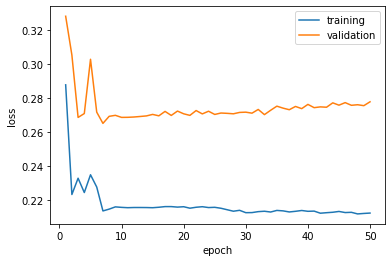

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib

# Set the model to evaluate mode
model.eval()
matplotlib.rcParams.update({'font.size': 12})

# Get predictions for the test data
x = torch.Tensor(x_test).float()
predicted = torch.round(model(x).data)

# Plot the confusion matrix
cm = confusion_matrix(y_test, predicted.numpy())
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Reds)

plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["success", "failure"], rotation=45)
plt.yticks(tick_marks, ["success", "failure"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

NameError: ignored

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\n", model.state_dict()[param_tensor].numpy())

layer_1.weight 
 [[-7.6361716e-01 -9.6137363e-01 -1.2890092e+00]
 [-1.6484374e+00 -1.2446281e+00 -2.8065202e-01]
 [-3.7659967e-01 -1.7605126e-01 -4.0795925e-01]
 [-3.5579336e-01  3.8047922e-01  5.2891925e-02]
 [ 2.4721961e+00 -2.7543845e+00  8.4818310e-01]
 [-9.3265837e-01 -8.5103296e-02 -5.3403342e-01]
 [-6.4755523e-01 -8.7892908e-01 -1.1558753e+00]
 [-2.0547803e-01  1.9645396e-01 -2.6580483e-01]
 [ 8.8290489e-01  2.7862976e+00  2.4327371e+00]
 [-3.8864744e-01 -1.9766942e-01  3.0926931e-01]
 [-1.3255872e-01 -2.3699251e-03 -1.5114504e+00]
 [-7.0394403e-01 -7.9321200e-01 -1.1416259e+00]
 [ 1.8806453e+00  4.1271353e-01  2.3110182e+00]
 [ 2.6527099e-02 -7.9279184e-01  3.1459928e-01]
 [-9.1387916e-01 -9.9957138e-01 -1.2331336e+00]
 [-1.1269437e+00 -2.3560557e-01 -3.3136231e-01]]
layer_1.bias 
 [-1.521756   -1.3786477  -0.07650073 -0.434699   -0.9755504  -1.1950771
 -1.2158766  -0.5128177  -1.3196591  -0.33840418 -0.18374    -0.57373255
 -2.4192538  -1.4184285  -0.13554022 -1.1177669 ]
laye

In [ ]:
import numpy as np

a = np.array([[-7.6361716e-01, -9.6137363e-01, -1.2890092e+00],
              [-1.6484374e+00, -1.2446281e+00, -2.8065202e-01],
              [-3.7659967e-01, -1.7605126e-01, -4.0795925e-01],
              [-3.5579336e-01,  3.8047922e-01,  5.2891925e-02],
              [ 2.4721961e+00, -2.7543845e+00,  8.4818310e-01],
              [-9.3265837e-01, -8.5103296e-02, -5.3403342e-01],
              [-6.4755523e-01, -8.7892908e-01, -1.1558753e+00],
              [-2.0547803e-01,  1.9645396e-01, -2.6580483e-01],
              [ 8.8290489e-01,  2.7862976e+00,  2.4327371e+00],
              [-3.8864744e-01, -1.9766942e-01,  3.0926931e-01],
              [-1.3255872e-01, -2.3699251e-03, -1.5114504e+00],
              [-7.0394403e-01, -7.9321200e-01, -1.1416259e+00],
              [ 1.8806453e+00,  4.1271353e-01,  2.3110182e+00],
              [ 2.6527099e-02, -7.9279184e-01,  3.1459928e-01],
              [-9.1387916e-01, -9.9957138e-01, -1.2331336e+00],
              [-1.1269437e+00, -2.3560557e-01, -3.3136231e-01]])

np.sum(np.abs(a), axis=0)


array([13.45838566, 12.89763431, 14.41960515])